# Mounting Drive

In [ ]:
from google.colab import drive

  drive.mount("./gdrive", force_remount=True)

 %cd "./gdrive/My Drive/Colab_Notebooks/PSO/"

 !ls -l

# Importing Libraries

In [ ]:
#library
import pandas as pd
import numpy as np
import random as rnd
import os
import re
import time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

# Importing other tools
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn.metrics import accuracy_score, recall_score, precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

## Data cleaning and preprocessing

In [ ]:
coordinate_file_path = 'Vietnam CordinateFile.xlsx'
daluong_file_path = 'VietnamDatasets.xlsx'

df_coordinate = pd.read_excel(coordinate_file_path)
df_daluong = pd.read_excel(daluong_file_path)

In [ ]:
coordinate_columns = ['Well Point Number', 'Longitude and Latitude']
daluong_columns = ['well_code', 'na', 'k', 'ca2', 'mg2', 'fe3', 'fe2', 'cl', 'so4', 'hco3',
                   'co3', 'no2', 'hardness_general', 'no3', 'hardness_temporal',
                   'hardness_permanent', 'ph', 'co2_free', 'co2_depend', 'co2_infiltrate',
                   'sio2', 'tds105']

df_coordinate = df_coordinate[coordinate_columns]
df_daluong = df_daluong[daluong_columns]

## Removing Duplicates

In [ ]:
# Check for missing values and display the report
daluong_mean_columns = ['fe2', 'fe3', 'no2', 'no3', 'co2_infiltrate', 'sio2']
for col in daluong_mean_columns:
    df_daluong[col].fillna(df_daluong[col].mean(), inplace=True)

# Drop rows with missing values show the results with indicative rows that are dropped.
df_daluong.dropna(subset=daluong_columns, inplace=True)

df_daluong.drop_duplicates(inplace=True)

## Data Validation and Encoding

In [ ]:
df_coordinate[['Longitude', 'Latitude']] = df_coordinate['Longitude and Latitude'].str.split(',', expand=True)
df_coordinate.drop('Longitude and Latitude', axis=1, inplace=True)
df_coordinate.rename({'Well Point Number': 'well_code'}, axis=1, inplace=True)

In [ ]:
def remove_outliers_iqr(dataframe, column):
    '''
    Remove outliers using the IQR method
    :param dataframe:
    :param column:
    :return:
    '''
    Q1 = dataframe[column].quantile(0.05)
    Q3 = dataframe[column].quantile(0.95)
    IQR = Q3 - Q1
    df = dataframe[~((dataframe[column] < (Q1 - 1.5 * IQR)) | (dataframe[column] > (Q3 + 1.5 * IQR)))]
    return df


df_daluong = remove_outliers_iqr(df_daluong, 'cl')

In [ ]:
df_daluong_tmp = df_daluong.copy(deep=True)
def binarize(column, threshold):
    '''
    Binarize the column based on the threshold
    :param column:
    :param threshold:
    :return:
    '''
    return column.apply(lambda x: 1 if x <= threshold else 0)


def binarize_inclusive(column, lower_bound, upper_bound):
    '''
    Binarize the column based on the lower and upper bounds
    :param column:
    :param lower_bound:
    :param upper_bound:
    :return:
    '''
    return column.apply(lambda x: 1 if (x >= lower_bound and x <= upper_bound) else 0)

df_daluong_tmp['ph'] = binarize_inclusive(df_daluong_tmp['ph'], 5.5, 8.5)
df_daluong_tmp['fe2'] = binarize(df_daluong_tmp['fe2'], 5)
df_daluong_tmp['fe3'] = binarize(df_daluong_tmp['fe3'], 5)
df_daluong_tmp['cl'] = binarize(df_daluong_tmp['cl'], 250)
df_daluong_tmp['so4'] = binarize(df_daluong_tmp['so4'], 400)
df_daluong_tmp['tds105'] = binarize(df_daluong_tmp['tds105'], 400)
df_daluong_tmp['hardness_general'] = binarize(df_daluong_tmp['hardness_general'], 500)
df_daluong_tmp['na'] = binarize(df_daluong_tmp['na'], 200)
df_daluong_tmp['k'] = binarize(df_daluong_tmp['k'], 12)
df_daluong_tmp['mg2'] = binarize(df_daluong_tmp['mg2'], 50)
df_daluong_tmp['ca2'] = binarize(df_daluong_tmp['ca2'], 75)
df_daluong_tmp['no3'] = binarize(df_daluong_tmp['no3'], 15)
df_daluong_tmp['no2'] = binarize(df_daluong_tmp['no2'], 1)
df_daluong_tmp['hco3'] = binarize(df_daluong_tmp['hco3'], 350)
df_daluong_tmp['co3'] = binarize(df_daluong_tmp['co3'], 1)
df_daluong_tmp['hardness_temporal'] = 1
df_daluong_tmp['hardness_permanent'] = 1
df_daluong_tmp['co2_free'] = 1
df_daluong_tmp['co2_depend'] = 1
df_daluong_tmp['co2_infiltrate'] = 1
df_daluong_tmp['sio2'] = 1

df_daluong['is_drinkable'] = df_daluong_tmp.drop('well_code', axis=1).apply(lambda row: int(row.nunique() == 1), axis=1)

In [ ]:
values = [200, 12, 75, 50, 5, 5, 250, 400, 350, 1, 1, 15, 8.5, 400, 500, 242, 393, 51, 127, 16, 5]
wi = [((1 / sum(values)) / value) for value in values]


def calculate_norm(dataframe, column, scale):
    if column == 'ph':
        return [100 * ((i - scale) / (8.5 - scale)) for i in dataframe[column]]
    else:
        return [100 * (i / scale) for i in dataframe[column]]


norm_values = dict()  # Empty dictionary to hold all the norm values

columns = ['ph', 'fe2', 'fe3', 'so4', 'tds105', 'hardness_general', 'no2', 'no3', 'ca2', 'mg2', 'co2_free',
           'co2_depend', 'co2_infiltrate', 'sio2', 'na', 'k', 'hco3', 'co3', 'cl', 'hardness_temporal',
           'hardness_permanent']

scales = [7, 5, 5, 400, 400, 500, 1, 15, 75, 50, 51, 127, 16, 42, 200, 12, 350, 1, 250, 242, 393]

for column, scale in zip(columns, scales):
    norm_values[column] = calculate_norm(df_daluong, column, scale)

df_daluong['wqi'] = 0
for i in range(len(df_daluong)):
    df_daluong['wqi'].iloc[i] = sum(norm_values[column][i] * weight for column, weight in zip(columns, wi)) / sum(wi)
# Scaling the wqi values between 0 and 100
df_daluong['wqi'] = (df_daluong['wqi'] - df_daluong['wqi'].min()) / (df_daluong['wqi'].max() - df_daluong['wqi'].min()) * 100

In [ ]:
# Quantile to classify the water quality
quantiles = df_daluong['wqi'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]).values

# Function to classify based on dynamic quantile ranges
def water_quality_class_quantile(x):
    if x <= quantiles[1]:
        return "Poor"
    elif quantiles[1] < x <= quantiles[2]:
        return "Fair"
    elif quantiles[2] < x <= quantiles[3]:
        return "Medium"
    elif quantiles[3] < x <= quantiles[4]:
        return "Good"
    elif quantiles[4] < x:
        return "Excellent"

df_daluong['wqc'] = df_daluong['wqi'].apply(water_quality_class_quantile)

In [ ]:
features_df = df_daluong[['well_code', 'na', 'hco3', 'hardness_permanent', 'co2_free', 'sio2', 'wqc']]
df_final = pd.merge(features_df, df_coordinate, on='well_code', how='inner')

df_final['Longitude'] = df_final['Longitude'].astype('float')
df_final['Latitude'] = df_final['Latitude'].astype('float')

df_final.dropna(inplace=True)

In [ ]:
# Encode the target variable
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

label_encoder_well_code = LabelEncoder()
df_final['well_code'] = label_encoder_well_code.fit_transform(df_final['well_code'])

X = df_final.drop(['wqc'], axis=1)
y_target = df_final['wqc']

In [ ]:
label_encoder = LabelEncoder()
y_target = label_encoder.fit_transform(y_target)
y_target = to_categorical(y_target)

label_cls = label_encoder.classes_

## Data Split

In [ ]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_target, test_size=0.1, random_state=0, stratify=y_target)

## Data Normalization

In [ ]:
# Normalize the features
from sklearn.preprocessing import MinMaxScaler

scaler_feature = MinMaxScaler()
X_train = scaler_feature.fit_transform(X_train)
X_test = scaler_feature.transform(X_test)

# Model Inputs

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Model Creation

In [ ]:
import tensorflow as tf
from pyswarm import pso

def create_model(layer_params):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv1D(layer_params[0], 3))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2, padding='same'))
    model.add(tf.keras.layers.Conv1D(layer_params[1]*2, 3))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2, padding='same'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=int(layer_params[2]), activation='relu'))
    model.add(tf.keras.layers.Dense(units=5, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# PSO Optimization

In [ ]:
def train_network(layer_params):
    mlp = create_model(layer_params)
    hst = mlp.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=20, verbose=0)
    return 1 - hst.history['accuracy'][-1]

In [ ]:
lb = [16, 32, 64]
ub = [64, 128, 128]

xopt, fopt = pso(train_network, lb, ub, swarmsize=5, omega=0.5, phip=0.5, phig=1.0, maxiter=30, minstep=1)

Stopping search: Swarm best position change less than 1


In [ ]:
# The optimized parameters
print("The otpimized parameters are:")
print("first filter 1D: ", int(xopt[0]))
print("second filter 1D: ", int(xopt[1]))
print("dense units: ", int(xopt[2]))

The otpimized parameters are:
first filter 1D:  64
second filter 1D:  108
dense units:  81


# Training the Model on a given particle (Hyperparmeters of the model)

In [ ]:
# Train the network with the optimized parameters
model = create_model(xopt)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=200)

Epoch 1/200
23/23 [==============================] - 2s 37ms/step - loss: 1.5985 - accuracy: 0.2712 - val_loss: 1.5839 - val_accuracy: 0.4125
Epoch 2/200
23/23 [==============================] - 0s 16ms/step - loss: 1.5711 - accuracy: 0.4339 - val_loss: 1.5573 - val_accuracy: 0.4375
Epoch 3/200
23/23 [==============================] - 0s 13ms/step - loss: 1.5436 - accuracy: 0.4618 - val_loss: 1.5262 - val_accuracy: 0.4500
Epoch 4/200
23/23 [==============================] - 0s 9ms/step - loss: 1.5115 - accuracy: 0.4812 - val_loss: 1.4915 - val_accuracy: 0.4875
Epoch 5/200
23/23 [==============================] - 0s 8ms/step - loss: 1.4750 - accuracy: 0.5076 - val_loss: 1.4510 - val_accuracy: 0.5625
Epoch 6/200
23/23 [==============================] - 0s 11ms/step - loss: 1.4340 - accuracy: 0.5160 - val_loss: 1.4046 - val_accuracy: 0.5125
Epoch 7/200
23/23 [==============================] - 0s 11ms/step - loss: 1.3852 - accuracy: 0.5271 - val_loss: 1.3522 - val_accuracy: 0.5500
Epoch 8/

# Evaluation of the model

Text(0.5, 1.0, 'Model Accuracy')

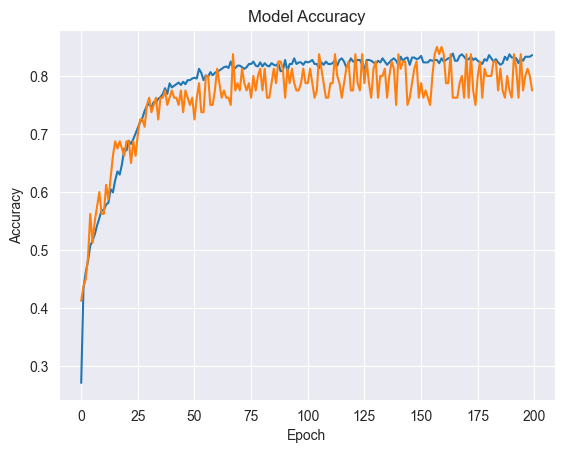

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

3/3 [==============================] - 0s 7ms/step - loss: 0.6041 - accuracy: 0.7750
Accuracy: 77.50%


In [ ]:
# Predictions
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

3/3 [==============================] - 0s 3ms/step


[Text(0, 0.5, 'Excellent'),
 Text(0, 1.5, 'Fair'),
 Text(0, 2.5, 'Good'),
 Text(0, 3.5, 'Medium'),
 Text(0, 4.5, 'Poor')]

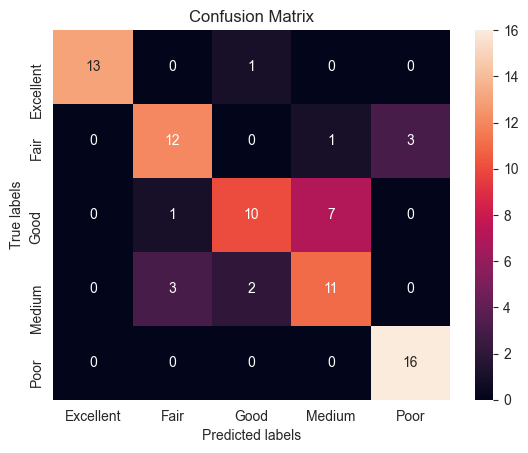

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(label_cls)
ax.yaxis.set_ticklabels(label_cls)

In [ ]:
# Classification report
print(classification_report(y_test, y_pred, target_names=label_cls))

              precision    recall  f1-score   support

   Excellent       1.00      0.93      0.96        14
        Fair       0.75      0.75      0.75        16
        Good       0.77      0.56      0.65        18
      Medium       0.58      0.69      0.63        16
        Poor       0.84      1.00      0.91        16

    accuracy                           0.78        80
   macro avg       0.79      0.78      0.78        80
weighted avg       0.78      0.78      0.77        80


# **Predictions**

In [ ]:
# from tqdm import tqdm
#
# df_final['predicted_wqc'] = ''
#
# for idx, row in tqdm(df_final.iterrows(), total=df_final.shape[0]):
#     features = row.drop(['wqc', 'predicted_wqc'])
#     features = scaler_feature.transform([features])
#     prediction = model.predict(features, verbose=0)
#     prediction = np.argmax(prediction, axis=1)
#     label = label_cls[prediction[0]]
#     df_final.at[idx, 'predicted_wqc'] = label